In [1]:
# -*- coding: utf-8 -*-
###############################################################################

# This notebook implements the plots in the Chapter 5.1 of the paper.  
# https://arxiv.org/pdf/1007.1727v3.pdf

# Author: Haoran Zhao
# Email: hrzhao76 AT gmail.com
###############################################################################

In [2]:
from utils import *

# Figure 3(a)

100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


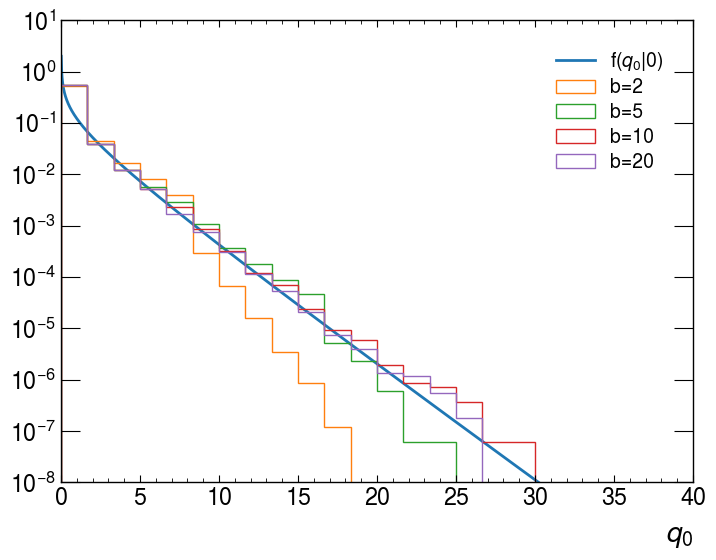

In [3]:
s = 10  # number of signal events
tau = 1 # scale factor, general unknown.

x_s = np.linspace(0.01, 40, 3001)

fig, ax = plt.subplots(figsize=(8, 6))
f_q0_x = f_q0(q0=x_s)
ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")


b_s = [2, 5, 10, 20]
mu = 0
N_trails = 10000000
for b in tqdm(b_s):
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
    q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
    ax.hist(q0_s, bins=24, range=(0, 40), density=True, histtype="step", label=f"b={b}")

ax.legend()
plt.show()

# Figure 3(b)

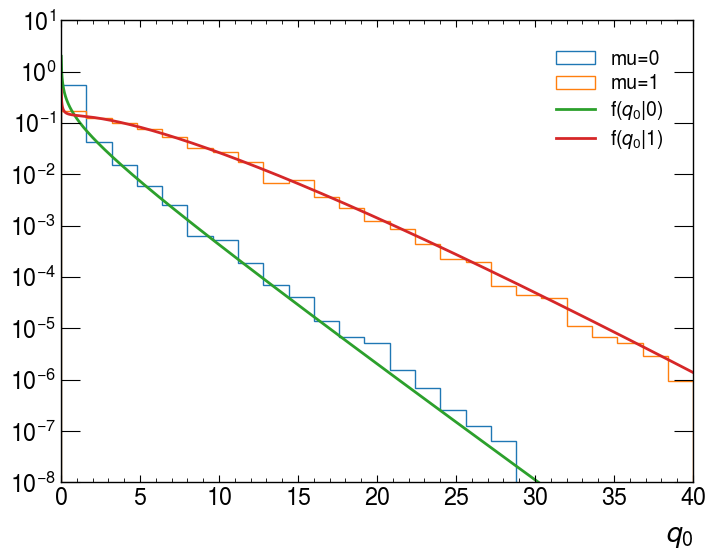

In [4]:
s = 10
b = 10
tau = 1
N_trails = 10000000

fig, ax = plt.subplots(figsize=(8, 6))
mu = 0
n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
ax.hist(q0_s, bins=25, range=(0, 40), density=True, histtype="step", label=f"mu=0")

mu = 1
n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
q0_1_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
ax.hist(q0_1_s, bins=25, range=(0, 40), density=True, histtype="step", label=f"mu=1")


x_s = np.linspace(0.01, 40, 3001)

f_q0_x = f_q0(q0=x_s)
f_q0_muprime_x = f_q0_muprime(q0=x_s, mu_prime=1, sigma=calSigma_Asimov(mu_prime=1, s=10, b=10, mu=0))

ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.plot(x_s, f_q0_muprime_x, label=r"f($q_0$|1)")

ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")
plt.show()

# DeV 

In [5]:
calSigma_Asimov(mu_prime=1, s=10, b=10, mu=0)

0.5424872603903438

In [6]:
calSigma_Cov(s=10, b=10, tau=1, mu_prime=1, N_trails=10000000)

0.5477337688483788